In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk(''):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import os

# Пути к данным
base_dir = "/kaggle/input/chest-xray-pneumonia/chest_xray"
train_dir = os.path.join(base_dir, "train")
test_dir = os.path.join(base_dir, "test")
val_dir = os.path.join(base_dir, "val")

# Проверка структуры папок
print("Train:", os.listdir(train_dir))
print("Test:", os.listdir(test_dir))
print("Validation:", os.listdir(val_dir))


Train: ['PNEUMONIA', 'NORMAL']
Test: ['PNEUMONIA', 'NORMAL']
Validation: ['PNEUMONIA', 'NORMAL']


In [3]:
def count_images_in_dir(directory):
    categories = ["NORMAL", "PNEUMONIA"]
    counts = {category: len(os.listdir(os.path.join(directory, category))) for category in categories}
    return counts

print("Train Data:", count_images_in_dir(train_dir))
print("Validation Data:", count_images_in_dir(val_dir))
print("Test Data:", count_images_in_dir(test_dir))


Train Data: {'NORMAL': 1341, 'PNEUMONIA': 3875}
Validation Data: {'NORMAL': 8, 'PNEUMONIA': 8}
Test Data: {'NORMAL': 234, 'PNEUMONIA': 390}


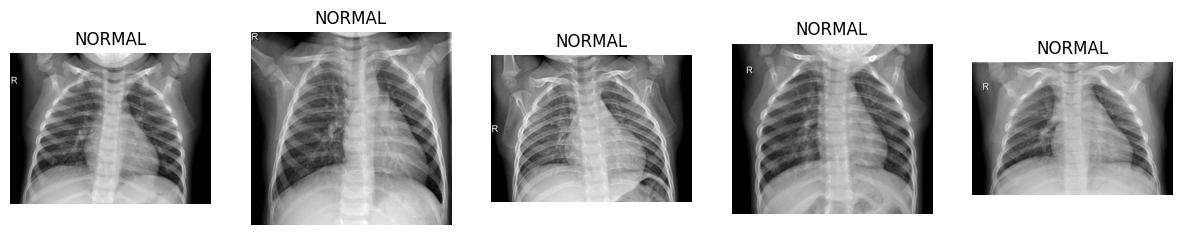

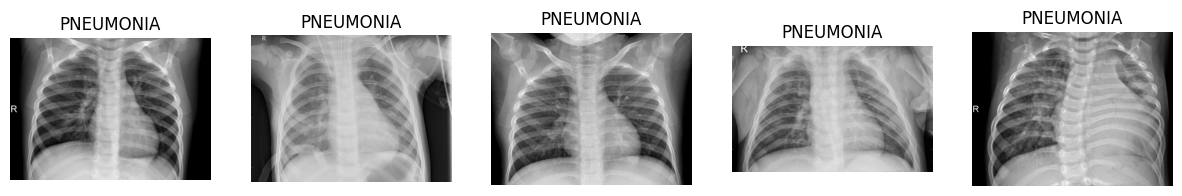

In [4]:
import matplotlib.pyplot as plt
import cv2
import random

def show_images_from_category(category, directory, num_images=5):
    images = os.listdir(os.path.join(directory, category))
    selected_images = random.sample(images, num_images)
    
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
    for i, img_name in enumerate(selected_images):
        img_path = os.path.join(directory, category, img_name)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        axes[i].imshow(img, cmap='gray')
        axes[i].axis("off")
        axes[i].set_title(category)
    plt.show()

# Отобразим несколько снимков из каждой категории в тренировочном наборе
show_images_from_category("NORMAL", train_dir)
show_images_from_category("PNEUMONIA", train_dir)


In [5]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [6]:
# Аугментация для тренировочных данных
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2  # 20% данных для валидации
)

# Загрузка тренировочных данных
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    subset='training'  # 80% для тренировки
)

# Загрузка валидационных данных
val_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    subset='validation'  # 20% для валидации
)

# Генератор для тестовых данных (без аугментации)
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)


Found 4173 images belonging to 2 classes.
Found 1043 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [7]:
import tensorflow as tf

model = tf.keras.Sequential([
    # Сверточный слой 1
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2,2),

    # Сверточный слой 2
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    # Сверточный слой 3
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    # Развертывание в плоский вектор
    tf.keras.layers.Flatten(),
    
    # Полносвязный слой
    tf.keras.layers.Dense(512, activation='relu'),
    
    # Dropout для регуляризации
    tf.keras.layers.Dropout(0.5),
    
    # Выходной слой (1 нейрон с активацией sigmoid)
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Компиляция модели
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

# Вывод структуры модели
model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 148, 148, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 72, 72, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 34, 34, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 17, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 36992)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │      18,940,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             513 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 19,034,177 (72.61 MB)

 Trainable params: 19,034,177 (72.61 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
checkpoint = tf.keras.callbacks.ModelCheckpoint('best_model.keras', save_best_only=True)


In [9]:
history = model.fit(
    train_generator,
    epochs=15,
    validation_data=val_generator,
    callbacks=[early_stop, checkpoint]
)


Epoch 1/15


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


131/131 ━━━━━━━━━━━━━━━━━━━━ 188s 1s/step - accuracy: 0.7484 - loss: 0.6684 - precision: 0.7746 - recall: 0.9382 - val_accuracy: 0.8571 - val_loss: 0.3096 - val_precision: 0.9151 - val_recall: 0.8903
Epoch 2/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 160s 1s/step - accuracy: 0.8873 - loss: 0.2815 - precision: 0.9176 - recall: 0.9324 - val_accuracy: 0.8773 - val_loss: 0.2727 - val_precision: 0.8989 - val_recall: 0.9406
Epoch 3/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 159s 1s/step - accuracy: 0.9079 - loss: 0.2192 - precision: 0.9304 - recall: 0.9447 - val_accuracy: 0.8974 - val_loss: 0.2255 - val_precision: 0.9165 - val_recall: 0.9484
Epoch 4/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 159s 1s/step - accuracy: 0.9177 - loss: 0.1988 - precision: 0.9388 - recall: 0.9513 - val_accuracy: 0.9185 - val_loss: 0.1934 - val_precision: 0.9302 - val_recall: 0.9626
Epoch 5/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 160s 1s/step - accuracy: 0.9284 - loss: 0.1816 - precision: 0.9468 - recall: 0.9561 - val_accuracy: 0.9233 - val_loss: 0.1918 -

In [10]:
model = tf.keras.models.load_model('best_model.keras')

test_loss, test_acc, test_precision, test_recall = model.evaluate(test_generator)

print(f"Test Accuracy: {test_acc:.2f}")
print(f"Test Precision: {test_precision:.2f}")
print(f"Test Recall: {test_recall:.2f}")


20/20 ━━━━━━━━━━━━━━━━━━━━ 11s 532ms/step - accuracy: 0.7634 - loss: 0.6893 - precision: 0.7058 - recall: 0.9963
Test Accuracy: 0.78
Test Precision: 0.75
Test Recall: 0.99


20/20 ━━━━━━━━━━━━━━━━━━━━ 8s 391ms/step


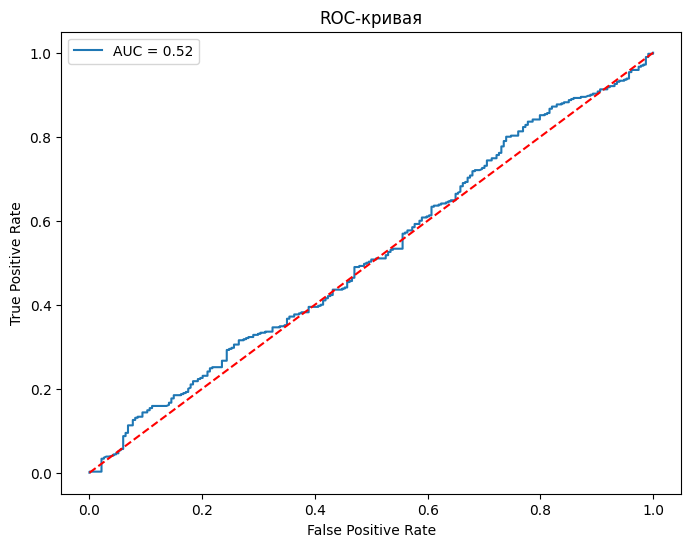

In [11]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

# Предсказания вероятностей
y_pred_probs = model.predict(test_generator).ravel()

# Истинные классы
y_true = test_generator.classes

# Вычисление ROC-кривой
fpr, tpr, thresholds = roc_curve(y_true, y_pred_probs)
roc_auc = auc(fpr, tpr)

# Построение графика
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], 'r--')  # Линия случайного угадывания
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.legend()
plt.show()


In [12]:
import numpy as np

# Порог для бинарной классификации
threshold = 0.5

# Истинные классы
y_true = test_generator.classes

# Предсказания модели (вероятности)
y_pred_probs = model.predict(test_generator).ravel()

# Бинарные предсказания (0 или 1)
y_pred = (y_pred_probs > threshold).astype(int)

# Найдём индексы ошибок
false_positives = np.where((y_pred == 1) & (y_true == 0))[0]  # FP: нормальные, но модель считает пневмонией
false_negatives = np.where((y_pred == 0) & (y_true == 1))[0]  # FN: пневмония, но модель считает нормой

print(f"False Positives: {len(false_positives)}")
print(f"False Negatives: {len(false_negatives)}")


20/20 ━━━━━━━━━━━━━━━━━━━━ 8s 392ms/step
False Positives: 198
False Negatives: 69


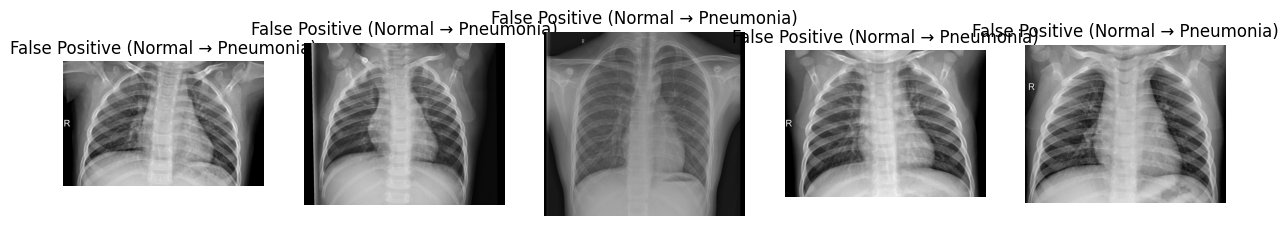

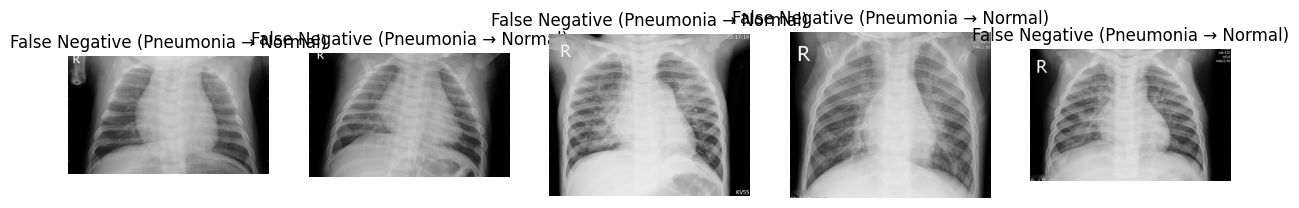

In [13]:
import matplotlib.pyplot as plt
import cv2

def plot_misclassified_images(indices, category, title, num_images=5):
    if len(indices) == 0:
        print(f"No misclassified {category} images to display.")
        return

    selected_indices = np.random.choice(indices, min(num_images, len(indices)), replace=False)
    
    fig, axes = plt.subplots(1, len(selected_indices), figsize=(15, 5))
    
    for i, idx in enumerate(selected_indices):
        img_path = test_generator.filepaths[idx]
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        axes[i].imshow(img, cmap='gray')
        axes[i].axis("off")
        axes[i].set_title(title)
    
    plt.show()

# Ложноположительные (FP) - нормальные, но модель считает пневмонией
plot_misclassified_images(false_positives, "FP", "False Positive (Normal → Pneumonia)")

# Ложноотрицательные (FN) - пневмония, но модель считает нормой
plot_misclassified_images(false_negatives, "FN", "False Negative (Pneumonia → Normal)")


In [15]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model

local_weights_path = "/kaggle/input/resnet50_weights/keras/default/1/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5"

# Загружаем ResNet50 с локальными весами
base_model = ResNet50(weights=local_weights_path, include_top=False, input_shape=(150, 150, 3))

# Замораживаем все сверточные слои
base_model.trainable = False

# Добавляем новые слои поверх ResNet
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation="relu")(x)
x = Dense(1, activation="sigmoid")(x)  # Выходной слой

# Создаём новую модель
model = Model(inputs=base_model.input, outputs=x)

# Компиляция модели
model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy", tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

# Вывод структуры модели
model.summary()


Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 150, 150, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 156, 156, 3)    │              0 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 75, 75, 64)     │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 75, 75, 64)     │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 75, 75, 64)     │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 77, 77, 64)     │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 38, 38, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 38, 38, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 38, 38, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 38, 38, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 38, 38, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 38, 38, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 38, 38, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 38, 38, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 38, 38, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 24,637,313 (93.98 MB)

 Trainable params: 1,049,601 (4.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [16]:
# Callbacks (остановка при отсутствии улучшений и сохранение лучшей модели)
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
checkpoint = tf.keras.callbacks.ModelCheckpoint('best_resnet.keras', save_best_only=True)

# Обучение модели
history = model.fit(
    train_generator,
    epochs=10,  # Сначала 10 эпох
    validation_data=val_generator,
    callbacks=[early_stop, checkpoint]
)


Epoch 1/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 227s 2s/step - accuracy: 0.7148 - loss: 0.6054 - precision_1: 0.7269 - recall_1: 0.9573 - val_accuracy: 0.7478 - val_loss: 0.4902 - val_precision_1: 0.7510 - val_recall_1: 0.9884
Epoch 2/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 216s 2s/step - accuracy: 0.7623 - loss: 0.4644 - precision_1: 0.7646 - recall_1: 0.9807 - val_accuracy: 0.7603 - val_loss: 0.4480 - val_precision_1: 0.7820 - val_recall_1: 0.9394
Epoch 3/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 254s 2s/step - accuracy: 0.7951 - loss: 0.4116 - precision_1: 0.8149 - recall_1: 0.9384 - val_accuracy: 0.7584 - val_loss: 0.4958 - val_precision_1: 0.9105 - val_recall_1: 0.7484
Epoch 4/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 214s 2s/step - accuracy: 0.7817 - loss: 0.4506 - precision_1: 0.8204 - recall_1: 0.9019 - val_accuracy: 0.7785 - val_loss: 0.4245 - val_precision_1: 0.8084 - val_recall_1: 0.9200
Epoch 5/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 254s 2s/step - accuracy: 0.8064 - loss: 0.4054 - precision_1: 0.8348 - recall_1: 0.9

In [17]:
# Размораживаем верхние 5 слоев ResNet
for layer in base_model.layers[-5:]:
    layer.trainable = True

# Компилируем модель с уменьшенным learning rate
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss="binary_crossentropy",
    metrics=["accuracy", tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

# Дообучение модели
history_finetune = model.fit(
    train_generator,
    epochs=5,  # Еще 5 эпох после разморозки
    validation_data=val_generator,
    callbacks=[early_stop, checkpoint]
)


Epoch 1/5
131/131 ━━━━━━━━━━━━━━━━━━━━ 270s 2s/step - accuracy: 0.7624 - loss: 0.8758 - precision_2: 0.8343 - recall_2: 0.8301 - val_accuracy: 0.8313 - val_loss: 0.3391 - val_precision_2: 0.8439 - val_recall_2: 0.9484
Epoch 2/5
131/131 ━━━━━━━━━━━━━━━━━━━━ 258s 2s/step - accuracy: 0.8682 - loss: 0.2838 - precision_2: 0.9063 - recall_2: 0.9203 - val_accuracy: 0.8466 - val_loss: 0.3039 - val_precision_2: 0.8917 - val_recall_2: 0.9032
Epoch 3/5
131/131 ━━━━━━━━━━━━━━━━━━━━ 218s 2s/step - accuracy: 0.8846 - loss: 0.2686 - precision_2: 0.9175 - recall_2: 0.9265 - val_accuracy: 0.8399 - val_loss: 0.3309 - val_precision_2: 0.8355 - val_recall_2: 0.9768
Epoch 4/5
131/131 ━━━━━━━━━━━━━━━━━━━━ 257s 2s/step - accuracy: 0.8896 - loss: 0.2619 - precision_2: 0.9194 - recall_2: 0.9316 - val_accuracy: 0.8466 - val_loss: 0.3546 - val_precision_2: 0.8383 - val_recall_2: 0.9832
Epoch 5/5
131/131 ━━━━━━━━━━━━━━━━━━━━ 231s 2s/step - accuracy: 0.8873 - loss: 0.2665 - precision_2: 0.9205 - recall_2: 0.9272 -

In [18]:
model = tf.keras.models.load_model('best_resnet.keras')

test_loss, test_acc, test_precision, test_recall = model.evaluate(test_generator)

print(f"Test Accuracy: {test_acc:.2f}")
print(f"Test Precision: {test_precision:.2f}")
print(f"Test Recall: {test_recall:.2f}")


20/20 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.8432 - loss: 0.3844 - precision_2: 0.8273 - recall_2: 0.9568
Test Accuracy: 0.85
Test Precision: 0.82
Test Recall: 0.97


20/20 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step


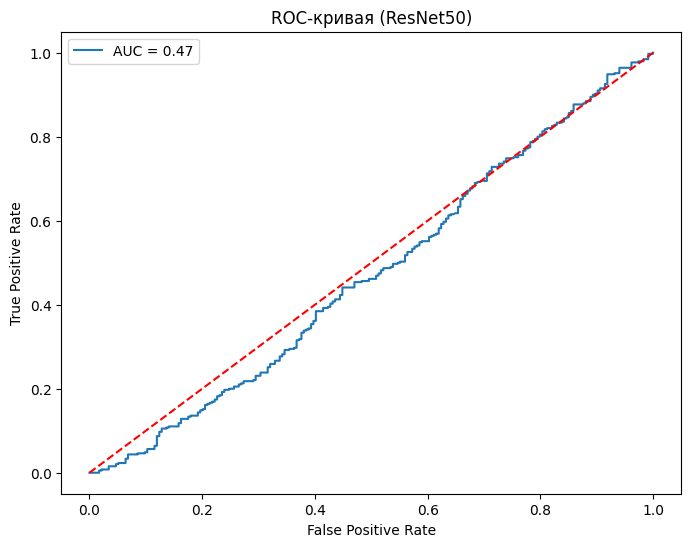

In [19]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Предсказания вероятностей
y_pred_probs = model.predict(test_generator).ravel()

# Истинные классы
y_true = test_generator.classes

# Вычисление ROC-кривой
fpr, tpr, thresholds = roc_curve(y_true, y_pred_probs)
roc_auc = auc(fpr, tpr)

# Построение графика
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], 'r--')  # Линия случайного угадывания
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая (ResNet50)')
plt.legend()
plt.show()


In [23]:
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(y_true, y_pred)
# y_pred_probs
mse_resnet = mean_squared_error(y_true, y_pred_probs)
print(f"Base -- Mean Squared Error (MSE): {mse:.4f}")
print(f"ResNet -- Mean Squared Error (MSE): {mse_resnet:.4f}")

Base -- Mean Squared Error (MSE): 0.4279
ResNet -- Mean Squared Error (MSE): 0.3713


In [24]:
import numpy as np

rmse = np.sqrt(mean_squared_error(y_true, y_pred))

rmse_resnet = np.sqrt(mean_squared_error(y_true, y_pred_probs))
print(f"Base -- Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"ResNet -- Root Mean Squared Error (RMSE): {rmse_resnet:.4f}")

Base -- Root Mean Squared Error (RMSE): 0.6541
ResNet -- Root Mean Squared Error (RMSE): 0.6093


In [25]:
from sklearn.metrics import r2_score

r2 = r2_score(y_true, y_pred)
r2_resnet = r2_score(y_true, y_pred_probs)
print(f"Base -- R² (Coefficient of Determination): {r2:.4f}")
print(f"Resnet -- R² (Coefficient of Determination): {r2_resnet:.4f}")

Base -- R² (Coefficient of Determination): -0.8256
Resnet -- R² (Coefficient of Determination): -0.5841
